In [1]:
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import autokeras as ak
import os 
import time
import importlib
import logging
import glob
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
        
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

!nvidia-smi

INFO:root:numpy Version is 1.19.5
INFO:root:tensorflow Version is 2.4.0
INFO:root:



1 Physical GPUs, 1 Logical GPU
Wed Dec  8 15:18:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:48:00.0 Off |                    0 |
| N/A   30C    P0    82W / 400W |  21399MiB / 81251MiB |     31%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                         

# Load The Best Model

In [2]:
%%time
#Load Model
experiment = "dune"

# model_path = "/dicos_ui_home/alanchung/ML4NO/ATM_DEMO/model/0910_2params_4_1_1.h5"
# model_path = "/dicos_ui_home/alanchung/ML4NO/ATM_DEMO/Reproduce/models_PoissonTrain/1208_trail_2_2params_1_1_1_v1.h5"
model_path = "/dicos_ui_home/alanchung/ML4NO/ATM_DEMO/Reproduce/models_PoissonTrain/1208_2params_1_1_1_v3.h5"


if os.path.isfile(model_path):

    model = load_model(model_path, compile=False)
    model.summary()

else:
    logging.info("Please Check Input Files!!!")
    raise ValueError("Please Check Input Files!!!")

logging.info("\n")
logging.info("All Models are loaded!")

INFO:root:

INFO:root:All Models are loaded!


Model: "Regression_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BatchNormalization_input (Input [(None, 144)]        0                                            
__________________________________________________________________________________________________
BatchNormalization (BatchNormal (None, 144)          576         BatchNormalization_input[0][0]   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          74240       BatchNormalization[0][0]         
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
___________________________________________________________________________________

# Load Ideal Spectrum Based On The Best Fit

In [3]:
%%time

test_data = np.load('../Data/sample_NuFit0911.npz')

data_mid = np.column_stack([test_data['ve_dune'][:,:36], test_data['vu_dune'][:,:36], test_data['vebar_dune'][:,:36], test_data['vubar_dune'][:,:36]])
data_NO_mid = data_mid[0]
data_IO_mid = data_mid[1]

logging.info("Test IO Data Shape:{}".format(data_IO_mid.shape))
logging.info("Test NO Data Shape:{}".format(data_NO_mid.shape))

INFO:root:Test IO Data Shape:(144,)
INFO:root:Test NO Data Shape:(144,)


CPU times: user 4.86 ms, sys: 1.88 ms, total: 6.74 ms
Wall time: 5.58 ms


# Poisson Fluctuated Data Based On Ideal Spectrum

In [57]:
%%time


# N = 10000000
N = 5000000



IO_or_NO = 1# 0 for NO and 1 for IO


if IO_or_NO == 0:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))

    data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
    plot_name = "NO"
    
else:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    
    data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    plot_name = "IO"


INFO:root:IO
INFO:root:True point: theta_23 = 49.30 \delta_cp = 286.00


CPU times: user 1min 39s, sys: 4.59 s, total: 1min 44s
Wall time: 1min 44s


In [6]:
# %%time
# #Import txt檔

# #總資料組數
# N_DUNE = 92
# N_T2HK = 36
# N_DUT2 = 96

# theta23_DUNE = []
# delta_cp_DUNE = []
# chi_DUNE = []
# theta23_T2HK = []
# delta_cp_T2HK = []
# chi_T2HK = []
# theta23_DUT2 = []
# delta_cp_DUT2 = []
# chi_DUT2 = []


# f_DUNE = open("../Data/chi_square-4-2_figB_DUNE.txt")
# for i in range(N_DUNE):
#     s = f_DUNE.readline().split()
#     array = []
#     for j in range(len(s)) :
#         array.append(float(s[j])) 
#     theta23_DUNE.append(array[0])
#     delta_cp_DUNE.append(array[1]) 
#     chi_DUNE.append(array[2])
# f_DUNE.close()
# f_T2HK = open("../Data/chi_square-4-2_figB_T2HK.txt")
# for i in range(N_T2HK):
#     s = f_T2HK.readline().split()
#     array = []
#     for j in range(len(s)) :
#         array.append(float(s[j])) 
#     theta23_T2HK.append(array[0])
#     delta_cp_T2HK.append(array[1]) 
#     chi_T2HK.append(array[2])
# f_T2HK.close()
# f_DUT2 = open("../Data/chi_square-4-2_figB_DUT2.txt")
# for i in range(N_DUT2):
#     s = f_DUT2.readline().split()
#     array = []
#     for j in range(len(s)) :
#         array.append(float(s[j])) 
#     theta23_DUT2.append(array[0])
#     delta_cp_DUT2.append(array[1]) 
#     chi_DUT2.append(array[2])
# f_DUT2.close()


# theta23_DUNE = np.array(theta23_DUNE)
# delta_cp_DUNE = np.array(delta_cp_DUNE)
# chi_DUNE = np.array(chi_DUNE)
# theta23_T2HK = np.array(theta23_T2HK)
# delta_cp_T2HK = np.array(delta_cp_T2HK)
# chi_T2HK = np.array(chi_T2HK)
# theta23_DUT2 = np.array(theta23_DUT2)
# delta_cp_DUT2 = np.array(delta_cp_DUT2)
# chi_DUT2 = np.array(chi_DUT2)


# x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
# y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
# X0, Y0 = np.meshgrid(x0, y0)
# Z0 = np.zeros((len(X0),len(X0[0])))

# for i in range(len(theta23_DUNE)):
#     a = np.where(X0 == theta23_DUNE[i])[1][0]
#     b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
#     Z0[b][a] = 1

# x1 = np.linspace(min(theta23_T2HK)-3, max(theta23_T2HK)+3, 65)
# y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
# X1, Y1 = np.meshgrid(x1, y1)
# Z1 = np.zeros((len(X1),len(X1[0])))

# for i in range(len(theta23_T2HK)):
#     a = np.where(X1 == theta23_T2HK[i])[1][0]
#     b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
#     Z1[b][a] = 1

# x2 = np.linspace(min(theta23_DUT2)-3, max(theta23_DUT2)+3, 129)
# y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
# X2, Y2 = np.meshgrid(x2, y2)
# Z2 = np.zeros((len(X2),len(X2[0])))

# for i in range(len(theta23_DUT2)):
#     a = np.where(X2 == theta23_DUT2[i])[1][0]
#     b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
#     Z2[b][a] = 1

# Load 2D Contour From GLOBES

In [7]:
%%time
#Import txt檔
f_DUNE_NO = open("../Data/one_sigma_contour_DUNE_NO.dat")
f_DUNE_IO = open("../Data/one_sigma_contour_DUNE_IO.dat")


theta23_DUNE_NO = []
delta_cp_DUNE_NO = []
chi_DUNE_NO = []
theta23_DUNE_IO = []
delta_cp_DUNE_IO = []
chi_DUNE_IO = []

while True:
    s = f_DUNE_NO.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j]))
    if(len(array)>0):
        theta23_DUNE_NO.append(array[0])
        delta_cp_DUNE_NO.append(array[1]) 
        chi_DUNE_NO.append(array[2])
    else:
        break
while True:
    s = f_DUNE_IO.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    if(len(array)>0):
        theta23_DUNE_IO.append(array[0])
        delta_cp_DUNE_IO.append(array[1]) 
        chi_DUNE_IO.append(array[2])
    else:
        break

theta23_DUNE_NO = np.array(theta23_DUNE_NO)
delta_cp_DUNE_NO = np.array(delta_cp_DUNE_NO)
chi_DUNE_NO = np.array(chi_DUNE_NO)
theta23_DUNE_IO = np.array(theta23_DUNE_IO)
delta_cp_DUNE_IO = np.array(delta_cp_DUNE_IO)
chi_DUNE_IO = np.array(chi_DUNE_IO)


# DUNE_NO
a0 = min(theta23_DUNE_NO)*100-300
b0 = max(theta23_DUNE_NO)*100 + 300
c0 = min(delta_cp_DUNE_NO)*10-60
d0 = max(delta_cp_DUNE_NO)*10+60
x0 = np.linspace(int(a0), int(b0), int((b0 - a0) + 1))/100
y0 = np.linspace(int(c0), int(d0), int(d0 - c0 + 1))/10
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE_NO)):
    a = np.where(X0 == theta23_DUNE_NO[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE_NO[i])[0][0]
    Z0[b][a] = 1
    
    
# DUNE_IO
a1 = min(theta23_DUNE_IO)*100-300
b1 = max(theta23_DUNE_IO)*100 + 300
c1 = min(delta_cp_DUNE_IO)*10-60
d1 = max(delta_cp_DUNE_IO)*10+60
x1 = np.linspace(int(a1), int(b1), int((b1 - a1) + 1))/100
y1 = np.linspace(int(c1), int(d1), int(d1 - c1 + 1))/10
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_DUNE_IO)):
    a = np.where(X1 == theta23_DUNE_IO[i])[1][0]
    b = np.where(Y1 == delta_cp_DUNE_IO[i])[0][0]
    Z1[b][a] = 1

CPU times: user 1min 6s, sys: 156 ms, total: 1min 6s
Wall time: 1min 6s


# Prediction

In [58]:
%%time

model_version = "model_v3"

if model_version == "model_v1":
    input_theta23 = model.predict(data_poisson)[:,0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    input_delta = model.predict(data_poisson)[:,1]*36
    input_delta = input_delta.reshape(len(input_delta),)
    
elif model_version == "model_v2":
    input_theta23 = model.predict(data_poisson)[:,0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    tmp = model.predict(data_poisson)[:,1:3]
    tmp = np.arctan2(tmp[:,0],tmp[:,1])
    tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
    input_delta = tmp/np.pi*180 
    
elif model_version == "model_v3":
    input_theta23 = model.predict(data_poisson)[0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    tmp = model.predict(data_poisson)[1]
    tmp = np.arctan2(tmp[:,0],tmp[:,1])
    tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
    input_delta = tmp/np.pi*180 

CPU times: user 4min 21s, sys: 32.8 s, total: 4min 54s
Wall time: 4min 11s


# Binning For ML 2D Contour

In [65]:
%%time

# bins_theta23_globes = np.linspace(0, 360, int(360/(x0[1]-x0[0])))    
# bins_delta_globes  = np.linspace(0, 360, int(360/(y0[1]-y0[0])))    
# bins_theta23_globes = np.linspace(0, 360, int(360/(x1[1]-x1[0])))
# bins_delta_globes  = np.linspace(0, 360, int(360/(y1[1]-y1[0])))


bins_theta23_globes = np.linspace(0, 360, 3600) 
bins_delta_globes  = np.linspace(0, 360, 720) 

likeliregion, xedges, yedges = np.histogram2d(input_theta23, input_delta, bins = [bins_theta23_globes, bins_delta_globes])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

Maximum: theta23 [49.31369825], delta [282.89290682] 
CPU times: user 594 ms, sys: 81.3 ms, total: 675 ms
Wall time: 673 ms


# Make 2D Contour Plot

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: No contour levels were found within the data range.


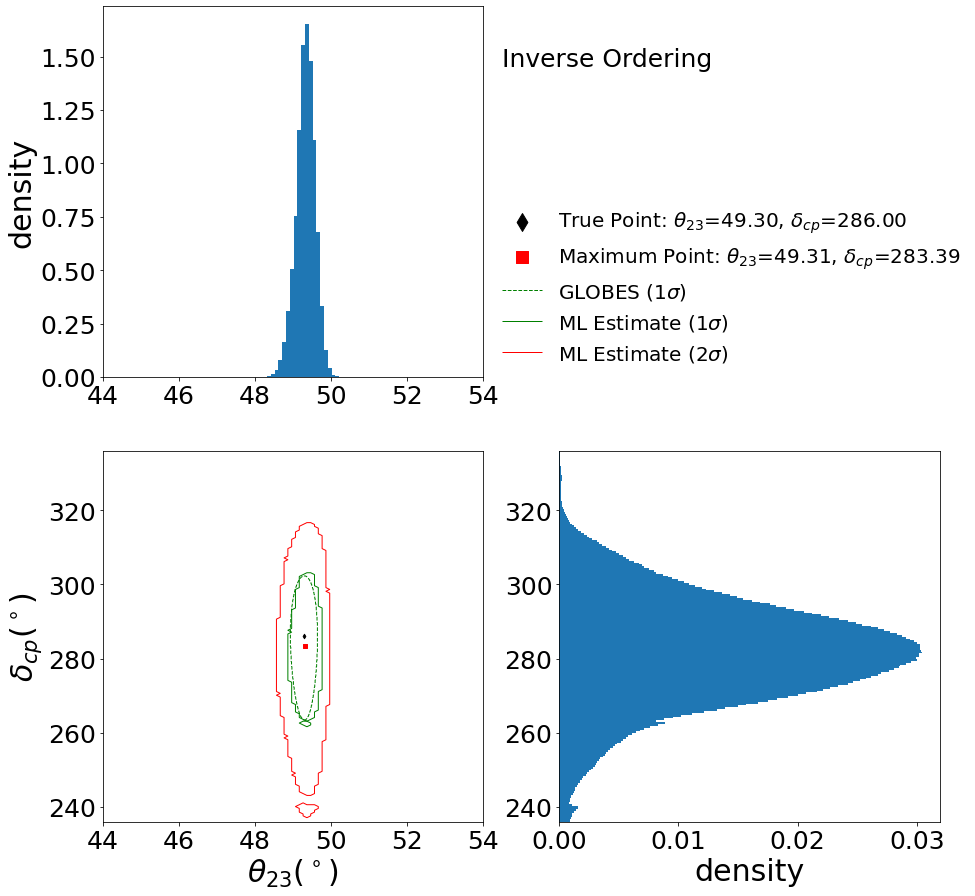

In [66]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(input_theta23,density=1,bins=bins_theta23_globes)
if IO_or_NO == 0:
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_xlim((44,54))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(input_delta,orientation="horizontal",density=1, bins=bins_delta_globes)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)


if IO_or_NO == 0:
    plot_axis.scatter(test_data['theta23'][0], test_data['delta'][0], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][0], test_data['delta'][0]))
else:
    plot_axis.scatter(test_data['theta23'][1], test_data['delta'][1], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][1], test_data['delta'][1]))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]+1], marker="s", c="r", s=10, label = "Maximum Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]+1][0]))
# plot_axis.scatter(xedges_asimov[max_poi_asimov[1]],yedges_asimov[max_poi_asimov[0]], marker="d", c="blue", s=5, label = "maximum point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges_asimov[max_poi_asimov[1]][0], yedges_asimov[max_poi_asimov[0]][0]))

    
"""
globes
"""
if IO_or_NO == 0:
    DU_NO = plot_axis.contour(X0, Y0, Z0, 0, colors='green', linestyles="--", linewidths=1 )
    DU_NO.collections[0].set_label("GLOBES (1$\sigma$)")

        
elif IO_or_NO == 1:
    DU_IO = plot_axis.contour(X1, Y1, Z1, 0, colors='green', linestyles="--", linewidths=1 )
    DU_IO.collections[0].set_label("GLOBES (1$\sigma$)")

# DUT2 = plot_axis.contour(X1, Y1, Z1, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("T2HK")

# DUT2 = plot_axis.contour(X2, Y2, Z2, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE + T2HK")



# """
# ML (Asimov)
# """
# CS_1_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, one_sigma_region_boundary_asimov, 0, colors='green', linestyles=":", linewidths=1)
# CS_2_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, two_sigma_region_boundary_asimov, 0, colors='red', linestyles=":", linewidths=1)
# CS_1_sigma_asimov.collections[0].set_label("Learnt Asimov (1$\sigma$)")
# CS_2_sigma_asimov.collections[0].set_label("Learnt Asimov (2$\sigma$)")



"""
ML (Poisson)
"""
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("ML Estimate (1$\sigma$)")
CS_2_sigma.collections[0].set_label("ML Estimate (2$\sigma$)")


plot_axis.set_xlabel(r'$\theta_{23} $($^\circ$)', fontsize=30)
plot_axis.set_ylabel(r'$\delta_{cp} $($^\circ$)', fontsize=30)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
    plot_axis.set_xlim((44,54))
else:
    raise ValueError("aaaa")
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

if IO_or_NO == 0:
    plt.text(x=54.5,y=355, s="Normal Ordering", fontsize=25 )
#     plt.text(x=54.5,y=340, s= str(index)+" Training", fontsize=25 )
    
elif IO_or_NO == 1:
    plt.text(x=54.5,y=440, s="Inverse Ordering", fontsize=25 )
#     plt.text(x=54.5,y=430, s= str(index)+" Training", fontsize=25 ) 

# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.savefig("./Plots/DUNE_to_5GeV_"+str(plot_name)+"_2D_Contour_"+str(N)+".png", transparent=True, bbox_inches='tight') 
plt.show()

# Goodness Study

In [44]:
%%time


IO_or_NO = 0# 0 for NO and 1 for IO

if IO_or_NO == 0:
    logging.info("NO")
    mc_test_data = np.load('../Data/best_fit_spectrum_deltacp_theta23_DUT2_NO.npz')
    ordering = "Normal Ordering"
    plot_name = "NO"
    
elif IO_or_NO == 1:
    logging.info("IO")
    mc_test_data = np.load('../Data/best_fit_spectrum_deltacp_theta23_DUT2_IO.npz')
    ordering = "Inverse Ordering"
    plot_name = "IO"

theta23_true = mc_test_data["theta23_true"]/(2*np.pi)*360
delta_true = mc_test_data["delta_true"]
theta23_best_fit = mc_test_data["theta23_fit"]/(2*np.pi)*360
delta_best_fit = mc_test_data["delta_fit"]

parameter_range = np.where(np.logical_and(delta_true >= 0, delta_true <= 360 ))[0][:100]


theta23_true = theta23_true[parameter_range]
delta_true = delta_true[parameter_range]
theta23_best_fit = theta23_best_fit[parameter_range]
delta_best_fit = delta_best_fit[parameter_range]

mc_data = np.column_stack([mc_test_data["ve_dune_poisson"][:,1:37],
                           mc_test_data["vu_dune_poisson"][:,1:37],
                           mc_test_data["vebar_dune_poisson"][:,1:37],
                           mc_test_data["vubar_dune_poisson"][:,1:37]])

mc_data = mc_data[parameter_range]


logging.info("MC Data Shape:{}".format(mc_data.shape))
logging.info("theta23 true Shape:{}".format(theta23_true.shape))
logging.info("delta true Shape:{}".format(delta_true.shape))
logging.info("theta23 best fit Shape:{}".format(theta23_best_fit.shape))
logging.info("delta best fit Shape:{}".format(delta_best_fit.shape))

INFO:root:NO
INFO:root:MC Data Shape:(100, 144)
INFO:root:theta23 true Shape:(100,)
INFO:root:delta true Shape:(100,)
INFO:root:theta23 best fit Shape:(100,)
INFO:root:delta best fit Shape:(100,)


CPU times: user 9.73 ms, sys: 2.01 ms, total: 11.7 ms
Wall time: 10.7 ms


In [45]:
%%time

model_version = "model_v3"

if model_version == "model_v1":
    input_theta23 = model.predict(mc_data)[:,0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    input_delta = model.predict(mc_data)[:,1]*36
    input_delta = input_delta.reshape(len(input_delta),)
    
elif model_version == "model_v2":
    input_theta23 = model.predict(mc_data)[:,0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    tmp = model.predict(mc_data)[:,1:3]
    tmp = np.arctan2(tmp[:,0],tmp[:,1])
    tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
    input_delta = tmp/np.pi*180 
    
elif model_version == "model_v3":
    input_theta23 = model.predict(mc_data)[0]
    input_theta23 = input_theta23.reshape(len(input_theta23),)
    tmp = model.predict(mc_data)[1]
    tmp = np.arctan2(tmp[:,0],tmp[:,1])
    tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
    input_delta = tmp/np.pi*180 
    

CPU times: user 71.3 ms, sys: 11.9 ms, total: 83.2 ms
Wall time: 88.2 ms


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  


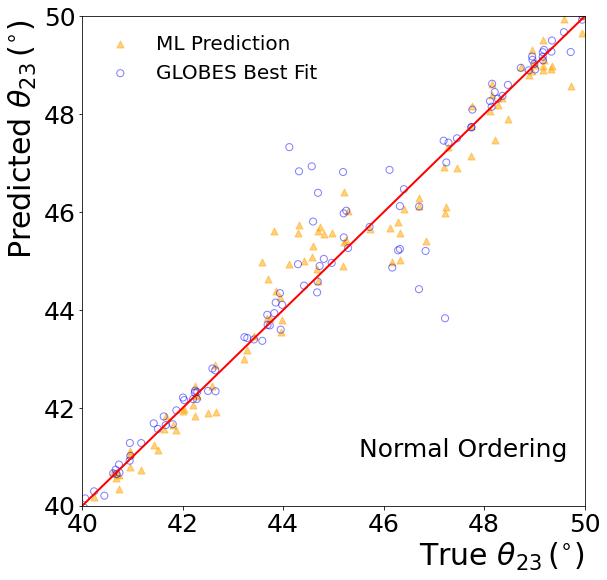

CPU times: user 359 ms, sys: 16.6 ms, total: 375 ms
Wall time: 373 ms


In [46]:
%%time

fig, ax = plt.subplots(1,1, figsize=(9,9))


plt.plot([40, 50],[40, 50], c="r", linewidth=2)
plt.scatter(theta23_true, input_theta23, color='orange', marker = "^", alpha=0.5, s=50, label="ML Prediction")
plt.scatter(theta23_true, theta23_best_fit, marker='o',c='',edgecolors='blue', alpha=0.5, s=50, label="GLOBES Best Fit")
plt.text(x=45.5,y=41, s=str(ordering), fontsize=25 )

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# plt.xlim((0.0008, 2.5))
# plt.xscale("log")
plt.xlim((40, 50))
plt.ylim((40, 50))
plt.xlabel("True $\\theta_{23}\,(^{\circ})$", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("Predicted $\\theta_{23}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)
# plt.grid()

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
plt.savefig("./Plots/DUNE_theta23_"+str(len(theta23_true))+"_the_best_model_"+str(plot_name)+".png", transparent=True, bbox_inches='tight') 


plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  


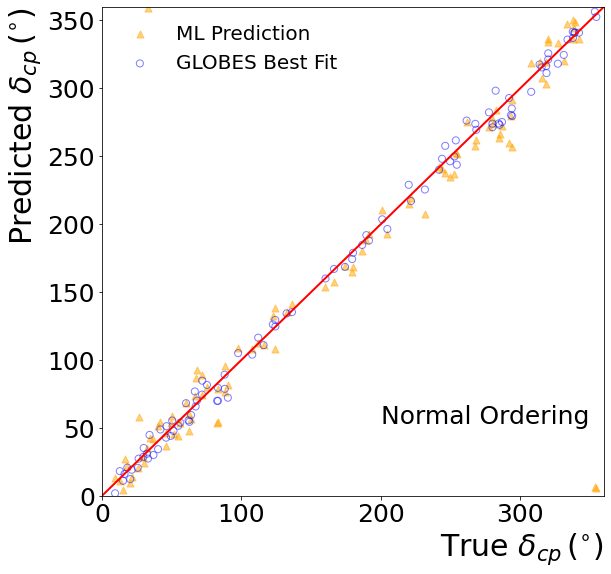

CPU times: user 350 ms, sys: 25.6 ms, total: 376 ms
Wall time: 374 ms


In [49]:
%%time

fig, ax = plt.subplots(1,1, figsize=(9,9))

plt.plot([0, 360],[0, 360], c="r", linewidth=2)

plt.scatter(delta_true, input_delta, color='orange', marker = "^", alpha=0.5, s=50, label="ML Prediction")
plt.scatter(delta_true, delta_best_fit, marker='o',c='',edgecolors='blue', alpha=0.5, s=50, label="GLOBES Best Fit")


# plt.text(x=20,y=300, s=str(ordering), fontsize=25 )
plt.text(x=200,y=53.3, s=str(ordering), fontsize=25 )


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

plt.xlim((0, 360))
plt.ylim((0, 360))
plt.xlabel("True $\delta_{cp}\,(^{\circ})$", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("Predicted $\delta_{cp}\,(^{\circ})$", fontsize=30, horizontalalignment='right',y=1)
# plt.grid()

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
plt.savefig("./Plots/DUNE_deltacp_"+str(len(delta_true))+"_the_best_model_"+str(plot_name)+".png", transparent=True, bbox_inches='tight') 


plt.show()

# TMP Test

In [55]:
# fig, ax = plt.subplots(1,1, figsize=(8,8))


# plt.scatter(xaxis[one_sigma_allowed_region[1]],yaxis[one_sigma_allowed_region[0]], s = 1)
# plt.contour(xaxis, yaxis, likeliregion, [one_sigma_num],
# #             corner_mask = False,
#             colors='green', 
#             linestyles="-", 
#             extend = "both",
#             linewidths=1)


# plt.contour(X0, Y0, Z0, 0, colors='green', linestyles="-", linewidths=1 )
# # plt.contourf(xaxis, yaxis, likeliregion, 60, cmap='RdGy')

# plt.ylim((145,245))
# plt.xlim((44,54))

# # plt.ylim((178,215))
# # plt.xlim((48.2,49.5))

# plt.show()

In [56]:
# # plt.hist(input_delta, bins=np.linspace(0, 360, 1000))
# # plt.xlim((145,245))

# plt.hist(input_theta23, bins=np.linspace(0, 100, 1000) )
# # plt.xlim((44,54))
# plt.show()